<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоги-исследования" data-toc-modified-id="Итоги-исследования-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоги исследования</a></span></li></ul></div>

# Восстановление золота из руды

Компания разрабатывает решения для эффективной работы промышленных предприятий.

Необходимо подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

**Цель исследования** — построить модель с минимальным значением Итоговой метрики sMAPE, которая спрогнозирует коэффициент восстановления золота из золотосодержащей руды.

**Ход исследования**

Данные с параметрами добычи и очистки будут получены из файлов `gold_recovery_train_new.csv`, `gold_recovery_test_new.csv`, `gold_recovery_full_new.csv`. О качестве данных ничего не известно. Поэтому перед началом исследования понадобится обзор данных. 
 
Исследование пройдёт в четыре этапа:
 1. Обзор и предобработка данных.
 2. Исследование данных.
 3. Построение модели.
 4. Тестирование модели.
 5. Выводы.

# Метрика качества

Для решения задачи введём новую метрику качества — *sMAPE* (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Метрика *sMAPE* вычисляется так:
$$sMAPE = \frac{1}{N}\sum_{i=1}^N\frac{|y_{i} - y'_{i}|}{(|y_{i}| + |y'_{i}|)/2} \times 100 \% $$

Нужно спрогнозировать сразу две величины:
- эффективность обогащения чернового концентрата `rougher.output.recovery`;
- эффективность обогащения финального концентрата `final.output.recovery`.

Итоговая метрика складывается из двух величин:

$$Итоговое sMAPE = 25\% \times sMAPE(rougher) + 75 \% \times sMAPE(final)$$

## Подготовка данных

In [35]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

In [2]:
# сохраним данные в переменные
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

Посмотрим на таблицы с данными

In [3]:
train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [4]:
test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [5]:
full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


Изучим общую информацию о датафреймах

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [8]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


**Проверим, что эффективность обогащения рассчитана правильно.**

Эффективность обогащения рассчитывается по формуле:
$$Recovery = \frac{C \times (F - T)}{F \times (C - T)} \times 100 \%$$

где:
- $C$ — доля золота в концентрате после флотации/очистки;
- $F$ — доля золота в сырье/концентрате до флотации/очистки;
- $T$ — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [9]:
c = train['rougher.output.concentrate_au'] # доля золота в концентрате после флотации/очистки;
f = train['rougher.input.feed_au'] # доля золота в сырье/концентрате до флотации/очистки
t = train['rougher.output.tail_au'] # доля золота в отвальных хвостах после флотации/очистки

train_recovery = 100 * (c * (f - t)) / (f * (c - t)) # эффективность обогащения 

print(mean_absolute_error(train['rougher.output.recovery'], train_recovery))

1.1131451184435918e-14


Значение среднего абсолютного отклонения небольшое - 1.1131451184435918e-14, т.е. можно сделать вывод: исходные данные об эффективности обогащения в датасете расчитаны правильно.

In [10]:
# Посмотрим на признаки, которых нет в тестовой выборке
columns_not_test = [column for column in train.columns if column not in test.columns]
columns_not_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

В тестовой выборке недоступны выходные (output) и расчетные (calculation) характеристики. Значит, их нельзя использовать при обучении, так как они еще не будут доступны к моменту начала процесса.

In [11]:
# посмотрим на долю пропусков
pd.DataFrame(round(train.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.500000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.700000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


Так как значения признаков сильно зависят от этапа обработки, заполним пропуски предыдущими значениями.

In [12]:
# Заполним пропуски методом ffill
train = train.fillna(method='ffill')

In [13]:
# посмотрим на долю пропусков в тестовой таблице
pd.DataFrame(round(test.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
date,0.000000
primary_cleaner.input.sulfate,0.100000
primary_cleaner.input.depressant,0.100000
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.100000
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000


In [14]:
# Заполним пропуски методом ffill
test = test.fillna(method='ffill')

In [15]:
# посмотрим на долю пропусков в полной таблице
pd.DataFrame(round(full.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
date,0.000000
final.output.concentrate_ag,0.000000
final.output.concentrate_pb,0.000000
final.output.concentrate_sol,1.100000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.500000
final.output.tail_sol,0.000000
final.output.tail_au,0.000000


In [16]:
# Заполним пропуски методом ffill
full = full.fillna(method='ffill')

**Вывод**

В полном датасете 19439 объектов. Данных достаточно для анализа и построения модели предсказания.

Целевые признаки находятся в столбцах `rougher.output.recovery`, `final.output.recovery`.
В тестовой выборке недоступны признаки, относящиеся к параметрам продукта и расчётным характеристикам.

Пропуски в данных были заполнены методом ffill.

Была проведена проверка эффективности обогащения, метрика MAE показала, что расчеты эффективности обогащения проведены верно.


## Анализ данных

**Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.**

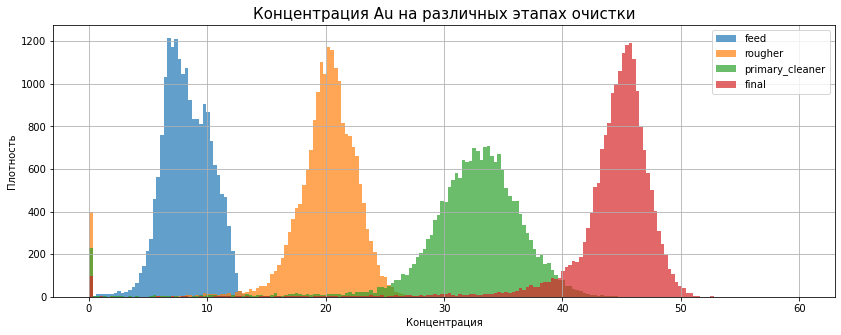

In [17]:
plt.figure(figsize=(14, 5))
full['rougher.input.feed_au'].hist(bins=200,range=(0,60),alpha=0.7, label = 'feed')
full['rougher.output.concentrate_au'].hist(bins=200,range=(0,60),alpha=0.7, label = 'rougher')
full['primary_cleaner.output.concentrate_au'].hist(bins=200,range=(0,60),alpha=0.7, label = 'primary_cleaner')
full['final.output.concentrate_au'].hist(bins=200,range=(0,60),alpha=0.7, label = 'final')

plt.grid(True)
plt.title('Концентрация Au на различных этапах очистки', fontsize=15)
plt.xlabel('Концентрация')
plt.ylabel('Плотность')
plt.legend()
plt.show()

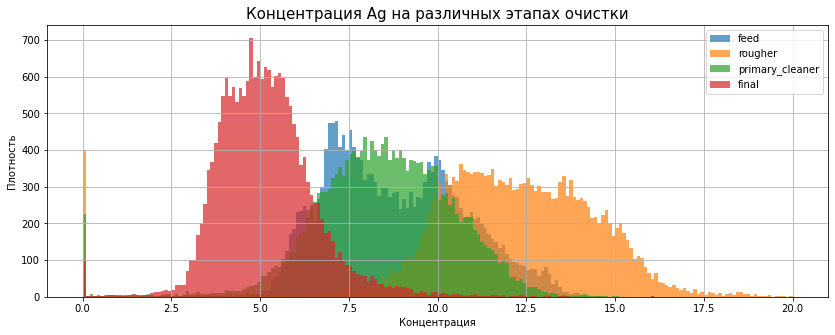

In [18]:
plt.figure(figsize=(14, 5))
full['rougher.input.feed_ag'].hist(bins=200,range=(0,20),alpha=0.7, label = 'feed')
full['rougher.output.concentrate_ag'].hist(bins=200,range=(0,20),alpha=0.7, label = 'rougher')
full['primary_cleaner.output.concentrate_ag'].hist(bins=200,range=(0,20),alpha=0.7, label = 'primary_cleaner')
full['final.output.concentrate_ag'].hist(bins=200,range=(0,20),alpha=0.7, label = 'final')

plt.grid(True)
plt.title('Концентрация Ag на различных этапах очистки', fontsize=15)
plt.xlabel('Концентрация')
plt.ylabel('Плотность')
plt.legend()
plt.show()

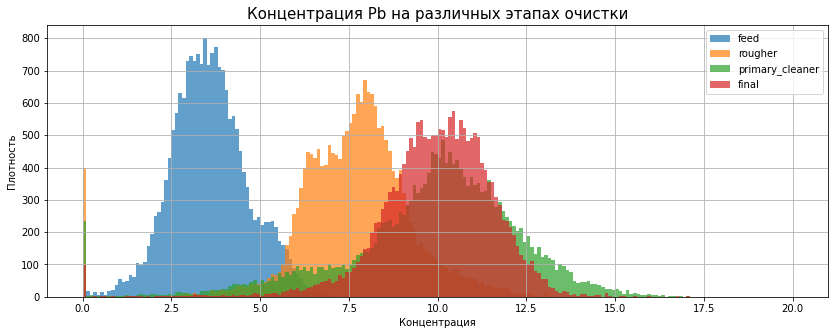

In [19]:
plt.figure(figsize=(14, 5))
full['rougher.input.feed_pb'].hist(bins=200,range=(0,20),alpha=0.7, label = 'feed')
full['rougher.output.concentrate_pb'].hist(bins=200,range=(0,20),alpha=0.7, label = 'rougher')
full['primary_cleaner.output.concentrate_pb'].hist(bins=200,range=(0,20),alpha=0.7, label = 'primary_cleaner')
full['final.output.concentrate_pb'].hist(bins=200,range=(0,20),alpha=0.7, label = 'final')

plt.grid(True)
plt.title('Концентрация Pb на различных этапах очистки', fontsize=15)
plt.xlabel('Концентрация')
plt.ylabel('Плотность')
plt.legend()
plt.show()

- Концентрация Au на каждом из этапов очистки планомерно увеличивается.
- Концентрация Ag после этапа флотации увеличивается, а далее с каждым этапом уменьшается.
- Концентрация Pb на этапах флотации и первичной очистки увеличивается, а после вторичной очистки практически не меняется.

Концентрация золота растет, значит мы на верном пути.

**Сравним распределения размеров гранул сырья на обучающей и тестовой выборках**

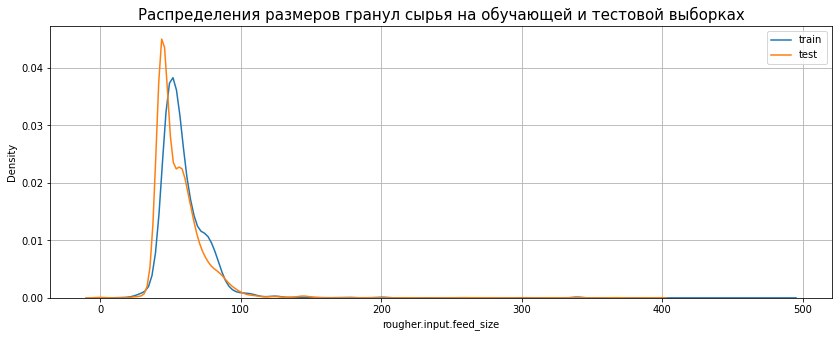

In [20]:
# Построим график плотности
plt.figure(figsize=(14, 5))
sns.kdeplot(data=train, x="rougher.input.feed_size", label='train')
sns.kdeplot(data=test, x="rougher.input.feed_size", label='test')

plt.grid(True)
plt.title('Распределения размеров гранул сырья на обучающей и тестовой выборках', fontsize=15)
plt.legend()
plt.show()

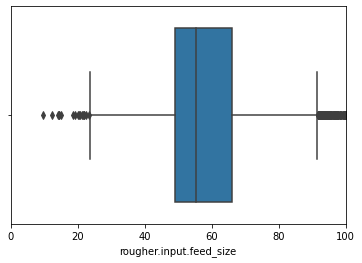

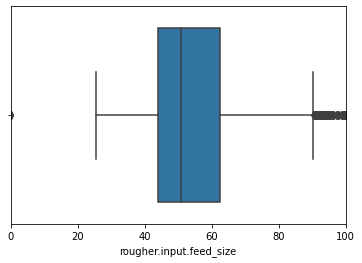

In [21]:
# Построим график «ящик с усами»
sns.boxplot(x="rougher.input.feed_size", data=train, orient="h")
plt.xlim(0, 100)
plt.show()
sns.boxplot(x="rougher.input.feed_size", data=test, orient="h")
plt.xlim(0, 100)
plt.show()

По построенным графикам можно заметить, что распределения размеров гранул сырья на обучающей и тестовой выборках примерно одинаковы.

**Исследуем суммарную концентрацию всех веществ на разных стадиях**

In [22]:
rougher_input = full['rougher.input.feed_au'] + full['rougher.input.feed_ag'] + full['rougher.input.feed_pb']
rougher_output = (full['rougher.output.concentrate_au'] + 
                  full['rougher.output.concentrate_ag'] + full['rougher.output.concentrate_pb'])
primary_cleaner_output = (full['primary_cleaner.output.concentrate_au'] + 
                        full['primary_cleaner.output.concentrate_ag'] + full['primary_cleaner.output.concentrate_pb'])
final_output = full['final.output.concentrate_au'] + full['final.output.concentrate_ag'] + full['final.output.concentrate_pb']

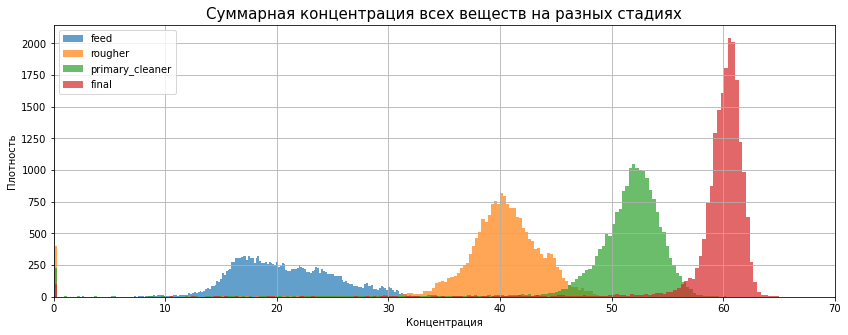

In [23]:
# Построим график суммарной концентрации
plt.figure(figsize=(14, 5))
rougher_input.hist(bins=200,alpha=0.7, label = 'feed')
rougher_output.hist(bins=200,alpha=0.7, label = 'rougher')
primary_cleaner_output.hist(bins=200,alpha=0.7, label = 'primary_cleaner')
final_output.hist(bins=200, alpha=0.7, label = 'final')

plt.xlim(0,70)
plt.grid(True)
plt.title('Суммарная концентрация всех веществ на разных стадиях', fontsize=15)
plt.xlabel('Концентрация')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Суммарная концентрация с каждой стадией растет.

**Вывод**

Было проведено исследование изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Показавшее, что концентрация Au на каждом из этапов увеличивается; концентрация Ag после этапа флотации увеличивается, а далее с каждым этапом уменьшается; концентрация Pb на этапах флотации и первичной очистки увеличивается, а после вторичной очистки практически не меняется. 

Суммарная концентрация всех веществ с каждой стадией растет.
Также были обнаружены выбросы концентрации в окрестности нуля, которые необходимо будет удалить перед обучением моделей.

Исследование распределения размеров гранул сырья на обучающей и тестовой выборках показало, что выборки примерно одинаковы.




## Обучение моделей

Подготовим наборы данных для обучения моделей

In [24]:
# Удалим выбросы в концентрации на тренировочной и тестовой выборках.
train = train.drop(index = train[train["rougher.input.feed_au"] < 1].index,axis = 0)
train = train.drop(index = train[train["rougher.input.feed_ag"] < 1].index,axis = 0)
train = train.drop(index = train[train["rougher.input.feed_pb"] < 1].index,axis = 0)
train = train.drop(index = train[train["rougher.input.feed_sol"] < 1].index,axis = 0)

test = test.drop(index = test[test["rougher.input.feed_au"] < 1].index,axis = 0)
test = test.drop(index = test[test["rougher.input.feed_ag"] < 1].index,axis = 0)
test = test.drop(index = test[test["rougher.input.feed_pb"] < 1].index,axis = 0)
test = test.drop(index = test[test["rougher.input.feed_sol"] < 1].index,axis = 0)

Создадим переменные для признаков и целевого признака на тренировочной выборке

In [25]:
features_train = train.drop(columns_not_test, axis=1) # удалим столбцы, которых нет в тренировочной выборке

features_train_rougher = features_train.drop(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level'], axis=1)
                                      
features_train_final = features_train.drop(['date'], axis=1) 
                                            
target_train_rougher = train['rougher.output.recovery']
target_train_final = train['final.output.recovery']

In [26]:
# Стандартизируем данные 
scaler = StandardScaler()
scaler.fit(features_train_rougher)

features_train_rougher = scaler.transform(features_train_rougher)
features_train_rougher = pd.DataFrame(data=features_train_rougher)

In [27]:
# Стандартизируем данные 
scaler = StandardScaler()
scaler.fit(features_train_final)

features_train_final = scaler.transform(features_train_final)
features_train_final = pd.DataFrame(data=features_train_final)

In [28]:
features_train_rougher

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-1.328417,-1.186170,0.481466,-0.203886,0.100871,-0.764873,0.059801,0.134093,0.113589,0.158353,...,1.538851,0.513404,1.416615,0.407780,1.846803,0.252418,1.716867,0.166198,2.173786,0.223690
1,-1.296132,-1.204072,0.498265,-0.126263,-0.116617,-0.768928,0.055097,0.132074,0.155725,0.163824,...,1.526563,0.248205,1.407756,0.271473,1.854348,0.276423,1.688780,0.247270,2.078958,0.255791
2,-1.319871,-1.304975,0.543875,-0.116215,-0.071635,-0.831280,0.039667,0.306034,0.135675,0.318905,...,1.518847,0.247246,1.403985,0.269260,1.851130,0.276413,1.688532,0.263725,2.082362,0.248595
3,-1.358753,-1.420485,0.664872,-0.103997,0.111928,-0.962046,-0.048941,0.311300,0.075450,0.312399,...,1.522778,0.236605,1.405574,0.270046,1.841053,0.273263,1.697969,0.262092,2.081895,0.261577
4,-1.349394,-1.658429,0.645047,-0.179604,-0.406350,-1.205582,-0.254010,0.307350,-0.118008,0.311042,...,1.523592,0.254362,1.407186,0.267832,1.850702,0.277208,1.701278,0.282442,2.087171,0.250711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13994,-1.332948,1.025745,0.841099,1.105579,0.216536,-1.381259,-1.228508,2.994483,-0.962166,2.702320,...,-0.928757,-0.601709,-1.174768,-0.596863,-1.247611,-0.604638,-1.254228,-0.606047,-1.056005,-0.578715
13995,-1.317284,0.577635,0.823212,2.568775,0.468356,-1.647708,-1.352367,3.127345,-1.139582,2.816874,...,-0.940369,-0.633359,-1.171953,-0.641899,-1.232750,-0.620230,-1.260385,-0.625021,-1.054552,-0.567668
13996,-1.397448,0.459117,0.790960,2.688472,0.773908,-1.815729,-1.587427,3.122492,-1.274746,2.818658,...,-0.928022,-0.652669,-1.167099,-0.635040,-1.218854,-0.661941,-1.257703,-0.628838,-1.052029,-0.745323
13997,-1.356191,0.347731,0.685494,2.752566,0.699684,-1.902688,-1.702080,3.120770,-1.373761,2.816285,...,-0.905454,-0.623408,-1.146508,-0.629469,-1.259481,-0.563708,-1.243920,-0.602976,-1.046956,-0.608229


**Напишем функцию для вычисления итоговой sMAPE**

In [29]:
# функция для вычисления метрики sMAPE
def smape1(y_true,y_predict):
    return np.mean(abs(y_true-y_predict) / ((abs(y_true) + abs(y_predict))/2)) * 100

In [30]:
# функция итогового sMAPE
def final_smape(smape_rougher, smape_final):
    return (0.25 * smape_rougher + 0.75 * smape_final)

In [31]:
# создадим свой скорринг для sMAPE
smape_score = make_scorer(smape1, greater_is_better=False)

Обучим разные модели и оценим их качество кросс-валидацией.

**Линейная регрессия**

In [32]:
# Обучим модель линейной регрессии для rougher
model = LinearRegression()
scores = cross_val_score(model, features_train_rougher, target_train_rougher, scoring=smape_score)
final_score = sum(scores)/len(scores)
abs(final_score)

12.460085205561992

In [33]:
# Обучим модель линейной регрессии для final
model = LinearRegression()
scores = cross_val_score(model, features_train_final, target_train_final, scoring=smape_score)
final_score = sum(scores)/len(scores)
abs(final_score)

11.971313778991835

In [34]:
# итоговое sMAPE для Линейной регрессии
final_smape(12.460085205561992,11.971313778991835)

12.093506635634373

**Случайный лес**

In [37]:
# Обучим модель случайного леса для rougher

model = RandomForestRegressor(random_state=12345)

param_rfr = {
    'max_depth': [1,3,5,7,9,11],
    'n_estimators': [10,50,100]
    }

random_search_rfr = RandomizedSearchCV(model, param_rfr, n_iter=10, scoring=smape_score, cv=5)
random_search_rfr.fit(features_train_rougher, target_train_rougher)

best_model_rfr = random_search_rfr.best_estimator_
best_params_rfr = random_search_rfr.best_params_
best_score_rfr = abs(random_search_rfr.best_score_)

print('Параметры лучшей модели random_forest для rougher:', best_params_rfr)
print('Оценка лучшей модели random_forest для rougher:', best_score_rfr)

Параметры лучшей модели random_forest для rougher: {'n_estimators': 100, 'max_depth': 3}
Оценка лучшей модели random_forest для rougher: 11.428520723388589


In [39]:
# Обучим модель случайного леса для final

model = RandomForestRegressor(random_state=12345)

param_rfr = {
    'max_depth': [1,3,5,7,9,11],
    'n_estimators': [10,50,100]
    }

random_search_rfr = RandomizedSearchCV(model, param_rfr, n_iter=10, scoring=smape_score, cv=5)
random_search_rfr.fit(features_train_final, target_train_final)

best_model_rfr_final = random_search_rfr.best_estimator_
best_params_rfr_final = random_search_rfr.best_params_
best_score_rfr_final = abs(random_search_rfr.best_score_)

print('Параметры лучшей модели random_forest для final:', best_params_rfr_final)
print('Оценка лучшей модели random_forest для final:', best_score_rfr_final)

Параметры лучшей модели random_forest для final: {'n_estimators': 10, 'max_depth': 5}
Оценка лучшей модели random_forest для final: 10.102170234416619


In [40]:
# итоговое sMAPE для случайного леса
final_smape(best_score_rfr, best_score_rfr_final)

10.43375785665961

**Catboost**

In [46]:
# Обучим модель Catboost для rougher

model = CatBoostRegressor(random_state=12345)

param_cb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [1,3,5,7,9,11],
    'iterations': [10,50,100,200]
    }

random_search_cb = RandomizedSearchCV(model, param_cb, n_iter=10, scoring=smape_score, cv=5)
random_search_cb.fit(features_train_rougher, target_train_rougher, verbose_eval=False)

best_model_cb = random_search_cb.best_estimator_
best_params_cb = random_search_cb.best_params_
best_score_cb = abs(random_search_cb.best_score_)

print('Параметры лучшей модели Catboost для rougher:', best_params_cb)
print('Оценка лучшей модели Catboost для rougher:', best_score_cb)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Параметры лучшей модели Catboost для rougher: {'learning_rate': 0.05, 'iterations': 200, 'depth': 11}
Оценка лучшей модели Catboost для rougher: 10.957704168125634


In [47]:
# Обучим модель Catboost для final

model = CatBoostRegressor(random_state=12345)

param_cb = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [1,3,5,7,9,11],
    'iterations': [10,50,100,200]
    }

random_search_cb = RandomizedSearchCV(model, param_cb, n_iter=10, scoring=smape_score, cv=5)
random_search_cb.fit(features_train_final, target_train_final, verbose_eval=False)

best_model_cb_final = random_search_cb.best_estimator_
best_params_cb_final = random_search_cb.best_params_
best_score_cb_final = abs(random_search_cb.best_score_)

print('Параметры лучшей модели Catboost для final:', best_params_cb_final)
print('Оценка лучшей модели Catboost для final:', best_score_cb_final)

Параметры лучшей модели Catboost для final: {'learning_rate': 0.05, 'iterations': 100, 'depth': 3}
Оценка лучшей модели Catboost для final: 9.663000375080733


In [48]:
# итоговое sMAPE для Catboost
final_smape(best_score_cb, best_score_cb_final)

9.986676323341957

Лучшее качество по метрике sMAPE показала модель CatBoost = 9.986.
Возьмем ее для проверки на тестовых данных.

## Тестирование

Подготовим тестовые данные.

In [55]:
# Добавим в тестовую таблицу целевые признаки
full_1 = full[['date', 'rougher.output.recovery', 'final.output.recovery']]
test_target = test.merge(full_1, on='date', how='left')

In [56]:
# Создадим переменные для признаков и целевого признака на тестовой выборке
features_test_rougher = test.drop(['date','primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level'], axis=1)

features_test_final = test.drop(['date'], axis=1)
target_test_rougher = test_target['rougher.output.recovery']
target_test_final = test_target['final.output.recovery']

In [58]:
# Стандартизируем данные 
scaler = StandardScaler()
scaler.fit(features_test_rougher)

features_test_rougher = scaler.transform(features_test_rougher)
features_test_rougher = pd.DataFrame(data=features_test_rougher)

scaler = StandardScaler()
scaler.fit(features_test_final)

features_test_final = scaler.transform(features_test_final)
features_test_final = pd.DataFrame(data=features_test_final)

Проведем проверку лучшей модели на тестовой выборке.

In [59]:
# Сделаем предсказание на тестовых данных с помощью лучших моделей Catboost
predictions_test_rougher = best_model_cb.predict(features_test_rougher)
predictions_test_final = best_model_cb_final.predict(features_test_final)

In [60]:
# рассчитаем итоговое sMAPE на тестовой выборке
final_smape(smape1(target_test_rougher,predictions_test_rougher),smape1(target_test_final,predictions_test_final))

9.313436103483076

Для того чтобы проконтролировать, что наша модель действительно дает нам прирост качества, сравним ее с константной моделью.

In [61]:
dummy_model_rougher = DummyRegressor(strategy="median")
dummy_model_final = DummyRegressor(strategy="median")

dummy_model_rougher.fit(features_train_rougher, target_train_rougher)
dummy_model_final.fit(features_train_final, target_train_final)

dummy_pred_r = dummy_model_rougher.predict(features_test_rougher)
dummy_pred_f = dummy_model_final.predict(features_test_final)

In [62]:
# рассчитаем итоговое sMAPE на тестовой выборке для константной модели
final_smape(smape1(target_test_rougher,dummy_pred_r),smape1(target_test_final,dummy_pred_f))

9.356625641095373

**Вывод**

Метрика лучшей модели на тестовых данных показала результат лучше, чем константная модель всего на 0.5%.

## Итоги исследования

Был проведен исследовательский анализ данных с параметрами добычи и очистки золота из золотосодержащей руды.

Проведено исследование изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки. Показавшее, что концентрация Au на каждом из этапов увеличивается; концентрация Ag после этапа флотации увеличивается, а далее с каждым этапом уменьшается; концентрация Pb на этапах флотации и первичной очистки увеличивается, а после вторичной очистки практически не меняется.

Суммарная концентрация всех веществ с каждой стадией растет.

Исследование распределения размеров гранул сырья на обучающей и тестовой выборках показало, что выборки примерно одинаковы.

Были построены три модели для решения задачи классификации (линейная регрессия, случайный лес и catboost) для первого и второго целевых признаков. Их качество оценивалось кросс-валидацией. Лучший результат показала модель catboost с гиперпараметрами `learning_rate`: 0.05, `iterations`: 200, `depth`: 11 для первого этапа очистки, и с гиперпараметрами `learning_rate`: 0.05, `iterations`: 100, `depth`: 3 для второго этапа. Итоговая метрика sMAPE 9.986.

Модель catboost была взята для проведения финального тестирования. Получена метрика sMAPE 9.313, которая оказалась лучше метрики константной модели всего на 0.5%.

Это может быть связано с тем, что данные для обучения и тестов немного отличаются. Для улучшения метрик можно попробовать по-другому обработать данные, поискать гиперпараметры в более широком диапазоне или же обучать на других алгоритмах.